In [1]:
#!pip install celery

In [2]:
#!sudo rabbitmqctl add_user myguest myguestpwd
#!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

In [ ]:
# On the workers you will neeed to run:
#celery -A kmeans_workers_v2 worker --loglevel=info --concurrency=4


In [3]:
!sudo rabbitmqctl list_users

Listing users ...
guest	[administrator]
myguest	[]


In [4]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from kmeans_workers_v2 import kmeans_tasks, dist, NumpyEncoder


In [5]:
n_samples=16000
n_clusters=3
n_features =2
n_workers = 4 #Check the celery also uses 4 workers!!!

In [6]:
np.random.seed(seed=1023)

In [7]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, shuffle =False)

In [8]:
Ys

array([0, 0, 0, ..., 2, 2, 2])

In [9]:
mydata= [{"points": x, "label": y} for x,y in zip(Xs,Ys)]

In [10]:
print(len(mydata))
print(mydata[15]['points'],mydata[15]['label'])

16000
[7.4123751  1.65861249] 0


In [11]:
# Split the sequence in a number of chunks and process those independently.

if 1:
    l = n_samples // n_workers
    Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
    Xsubseqs.append(mydata[(n_workers - 1) * l:])
else:
    splitting_points=[100,300,1000]
    Xsubseqs=[]
    Xsubseqs.append(mydata[0:splitting_points[0]])
    Xsubseqs.append(mydata[splitting_points[0]:splitting_points[1]])
    Xsubseqs.append(mydata[splitting_points[1]:splitting_points[2]])
    Xsubseqs.append(mydata[splitting_points[2]:])
    
for i in range(len(Xsubseqs)):
    print(len(Xsubseqs[i]))

4000
4000
4000
4000


In [12]:
np.matrix(np.diag(np.max(Xs,0)))

matrix([[11.87536783,  0.        ],
        [ 0.        ,  8.26562541]])

In [13]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)


Initial Centroids
[[10.71854272  0.65915336]
 [ 1.78003584  8.22716699]
 [ 3.07457675  0.19630368]]


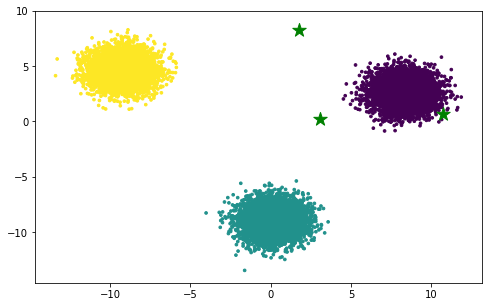

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

# Plotting along with the Centroids
#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata])
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [15]:
len([actdata['label'] for actdata in mydata])

16000

In [16]:
print(C)
print(C.shape)

[[10.71854272  0.65915336]
 [ 1.78003584  8.22716699]
 [ 3.07457675  0.19630368]]
(3, 2)


### Distributed Kmeans

In [17]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)

Initial Centroids
[[4.88339278 2.66107548]
 [7.57508402 8.02301434]
 [1.82534863 1.93882882]]


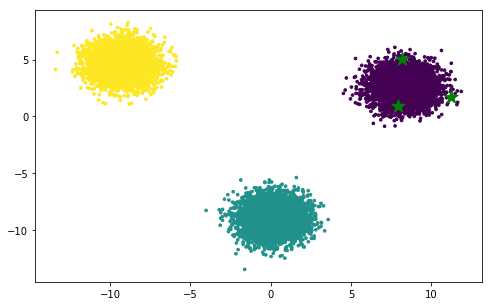

In [18]:
# Split the sequence in a number of chunks and process those independently.
n_iter =15

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [19]:
#Let us upload data to the workers
response = group(kmeans_tasks.s(task='data_to_workers', json_dump = json.dumps({'C': C, 'X': seq,'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 

response.get()

['success', 'success', 'success', 'success']

In [20]:
starttime = time.time()
for iter in range(0, n_iter): 
    lazy_partials_EMstep = group(kmeans_tasks.s(task='EM_step', json_dump = json.dumps({'C': C}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    # call remote workers to run the sort task 
    partials_EMstep = lazy_partials_EMstep.get() # will wait for the tasks to return
    
    #all wrokers are done with their tasks
    partials_C=[json.loads(seq)['C'] for seq in partials_EMstep]
    print(partials_C)
    partials_num_points=[json.loads(seq)['num_points'] for seq in partials_EMstep]
    print(partials_num_points)
    
    #aggregation by th server
    C=np.zeros([n_clusters,n_features])
    for i in range(n_clusters):
        for j in range(n_workers):
             C[i,:]=C[i,:]+partials_num_points[j][i]*np.array(partials_C[j][i])

    num_points=np.sum(np.array(partials_num_points),0)
    print('num_points in clusters:', num_points)
    
    for i in range(n_clusters):
        if num_points[i]>0:
            C[i,:]=C[i,:]/num_points[i]

endtime = time.time()
print('Elapsed time: ', endtime - starttime)

[[[1.896152108725441, -6.564050326426615], [9.935735761257064, 2.4740653413269458], [8.175320641659438, 3.670376335417819]], [[-0.8524849600444664, -7.584301764006748], [0.0, 0.0], [-9.226696734467964, 5.10747411216839]], [[8.028486686366369, 2.007054283565874], [9.915677748500627, 2.4255067043730456], [8.181807534387307, 3.7026391567882233]], [[-9.336968222457768, 3.4393001488030697], [0.0, 0.0], [-9.166082649421984, 5.07673311850492]]]
[[3410, 156, 434], [2997, 0, 1003], [2259, 447, 1294], [1065, 0, 2935]]
num_points in clusters: [9731  603 5666]
[[[0.0, 0.0], [8.288979581894651, 2.602338048078514], [0.0, 0.0]], [[0.18038482193912803, -8.94405974163125], [0.0, 0.0], [-9.220075446388815, 4.68601011155831]], [[0.18751871004756937, -8.960668027626799], [8.293866377063882, 2.612164071481718], [0.0, 0.0]], [[0.0, 0.0], [0.0, 0.0], [-9.211580933242773, 4.640766590321808]]]
[[0, 4000, 0], [2667, 0, 1333], [2666, 1334, 0], [0, 0, 4000]]
num_points in clusters: [5333 5334 5333]
[[[0.0, 0.0], 

In [21]:
partials_num_points

[[2667, 0, 1333], [0, 4000, 0], [2666, 1334, 0], [0, 0, 4000]]

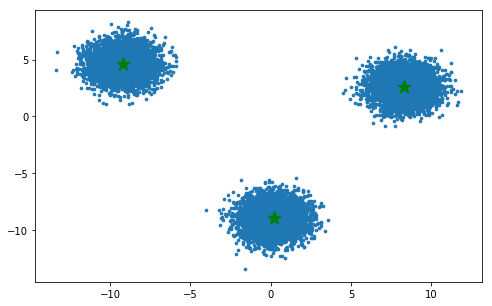

In [22]:
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
plt.show()
